In [1]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
!pip install -q transformers accelerate datasets


# **Loading Augmented Dataset**

In [2]:
import pandas as pd
!git clone https://github.com/mohammadentezari2001/LLM_HW1.git
!ls LLM_HW1/

train_augmented = pd.read_csv('LLM_HW1/Train_Augmented.csv', sep='\t')
train_augmented=train_augmented.drop(['premise_processed','hypothesis_processed','label_id'],axis=1)

Cloning into 'LLM_HW1'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), 940.49 KiB | 4.48 MiB/s, done.
Train_Augmented.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_augmented=train_augmented.sample(500)
# Split into train and validation (e.g., 80% train, 20% val)
train, val = train_test_split(train_augmented, test_size=0.2, random_state=42)

# # Save to new CSVs if needed
# train_data.to_csv("train.csv", index=False)
# val_data.to_csv("val.csv", index=False)

print("Train size:", len(train))
print("Validation size:", len(val))


Train size: 400
Validation size: 100


# **Last Layer Fine Tune**

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

Total number of layers: 18
Unfroze layer 17
Unfroze final layer norm
Trainable parameters: 5,574,272
Total parameters: 268,098,176
Percentage of trainable parameters: 2.08%


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/tmp/ipython-input-2764542021.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,4.633400,3.893019
2,3.456900,3.184246
3,2.965500,2.947147
4,2.710200,2.802033
5,2.567800,2.761352


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


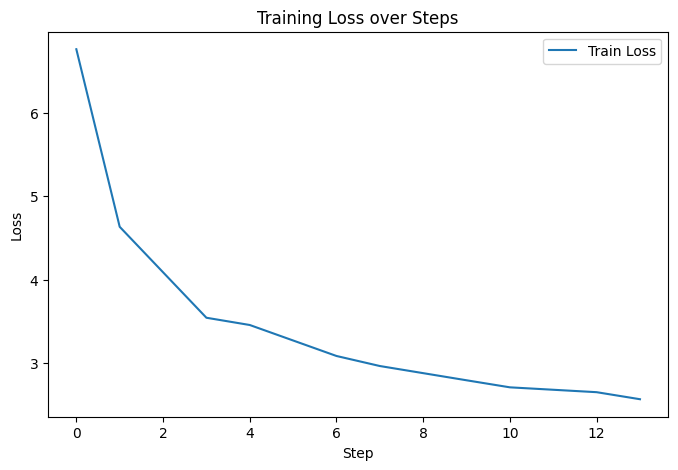

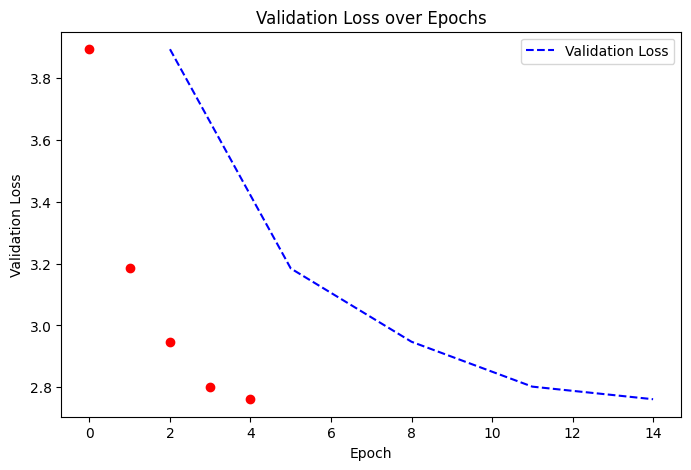

Training completed successfully!


In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

model_name = "google/gemma-3-270m"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last transformer block
num_layers = len(model.model.layers)
print(f"Total number of layers: {num_layers}")

# Unfreeze only the last layer
last_n_layers = 1
for i in range(num_layers - last_n_layers, num_layers):
    for param in model.model.layers[i].parameters():
        param.requires_grad = True
    print(f"Unfroze layer {i}")

# Unfreeze the final layer norm if it exists (this is small)
if hasattr(model.model, 'norm'):
    for param in model.model.norm.parameters():
        param.requires_grad = True
    print("Unfroze final layer norm")

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

# Add padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Prepare dataset
df = train.copy()
df1 = val.copy()

# Map labels
label2id = {"e": "e", "c": "c", "n": "n"}
df["label"] = df["label"].map(label2id)
df1["label"] = df1["label"].map(label2id)

# Fill missing reason 
df["reasoning"] = df["reasoning"].fillna("")
df1["reasoning"] = df1["reasoning"].fillna("")

# Build input and target
def make_input(row):
    return f"جمله اول: {row['premise']}\nجمله دوم: {row['hypothesis']}\nنتیجه:"

def make_target(row):
    return f"{row['reasoning']} [LABEL] {row['label']}"

df["input_text"] = df.apply(make_input, axis=1)
df["target_text"] = df.apply(make_target, axis=1)
df1["input_text"] = df1.apply(make_input, axis=1)
df1["target_text"] = df1.apply(make_target, axis=1)

train_ds = Dataset.from_pandas(df)
val_ds = Dataset.from_pandas(df1)

# Tokenization  
max_input_len = 256
max_target_len = 128

def tokenize_fn(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_len,
        truncation=True,
        padding=False
    )

    # Tokenize targets
    labels = tokenizer(
        examples["target_text"],
        max_length=max_target_len,
        truncation=True,
        padding=False
    )

    input_ids = []
    attention_mask = []
    labels_list = []

    for i in range(len(examples["input_text"])):
        # Tokenize input and target separately
        input_tokens = model_inputs["input_ids"][i]
        target_tokens = labels["input_ids"][i]

        # Combine input and target
        combined_input_ids = input_tokens + target_tokens + [tokenizer.eos_token_id]
        combined_attention_mask = [1] * len(combined_input_ids)

        # Create labels (we want to predict only the target part)
        # Use -100 for input part (to ignore in loss calculation)
        combined_labels = [-100] * len(input_tokens) + target_tokens + [tokenizer.eos_token_id]

        # Pad sequences to max length
        max_length = max_input_len + max_target_len + 1  # +1 for EOS

        if len(combined_input_ids) > max_length:
            combined_input_ids = combined_input_ids[:max_length]
            combined_attention_mask = combined_attention_mask[:max_length]
            combined_labels = combined_labels[:max_length]
        else:
            padding_length = max_length - len(combined_input_ids)
            combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
            combined_attention_mask = combined_attention_mask + [0] * padding_length
            combined_labels = combined_labels + [-100] * padding_length

        input_ids.append(combined_input_ids)
        attention_mask.append(combined_attention_mask)
        labels_list.append(combined_labels)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels_list
    }

# Apply tokenization
train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)

# TrainingArguments & Trainer
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # causal LM, not masked LM
    pad_to_multiple_of=8
)

training_args = TrainingArguments(
    output_dir="./gemma3_finetuned_reason_label",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",  
    save_strategy="epoch",
    logging_steps=50,
    bf16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to='none',
    save_total_limit=2,
    prediction_loss_only=True  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train
trainer.train()

# 6. Save final model
model.save_pretrained("./gemma3_textual_entailment_fa")
tokenizer.save_pretrained("./gemma3_textual_entailment_fa")

# Evaluation & plots
def extract_label_from_generation(text):
    """Extract label from generated text"""
    if "[LABEL]" in text:
        return text.split("[LABEL]")[-1].strip().split()[0]  
    return ""

# Manual evaluation function
def evaluate_model(trainer, dataset, tokenizer, num_samples=100):
    model.eval()
    predictions = []
    true_labels = []

    # Sample some examples for evaluation
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    for idx in indices:
        example = dataset[idx]

        input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)

        # Generate text
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred_label = extract_label_from_generation(generated_text)

        # Get true label (from the original target)
        # This is a bit tricky since we modified the dataset
        # You might need to store original labels separately

        predictions.append(pred_label)

    return predictions

# Plot training loss
logs = pd.DataFrame(trainer.state.log_history)
if 'loss' in logs.columns and len(logs) > 0:
    train_logs = logs[logs['loss'].notnull()]
    if not train_logs.empty:
        plt.figure(figsize=(8,5))
        plt.plot(train_logs['loss'], label="Train Loss")
        plt.title("Training Loss over Steps")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Plot eval loss
eval_logs = logs[logs['eval_loss'].notnull()]
if not eval_logs.empty:
    plt.figure(figsize=(8,5))
    plt.plot(eval_logs['eval_loss'], color='blue', linestyle='--', label="Validation Loss")
    plt.scatter(range(len(eval_logs)), eval_logs['eval_loss'], color='red')
    plt.title("Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.show()

print("Training completed successfully!")

# **Half Layer Fine Tune**

Total number of layers: 18
Unfroze layer 14
Unfroze layer 15
Unfroze layer 16
Unfroze layer 17
Unfroze final layer norm
Trainable parameters: 22,295,168
Total parameters: 268,098,176
Percentage of trainable parameters: 8.32%


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/tmp/ipython-input-2818400743.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss
1,10.418000,16.389324
2,6.317900,5.160409
3,3.992500,3.777560
4,3.320600,3.283793
5,2.880500,3.057397


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


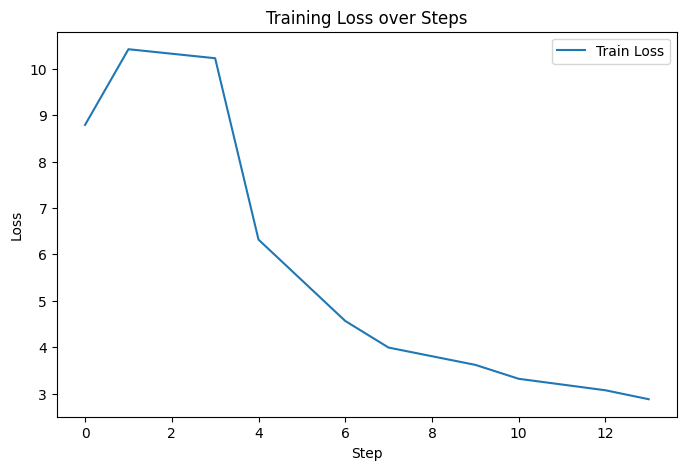

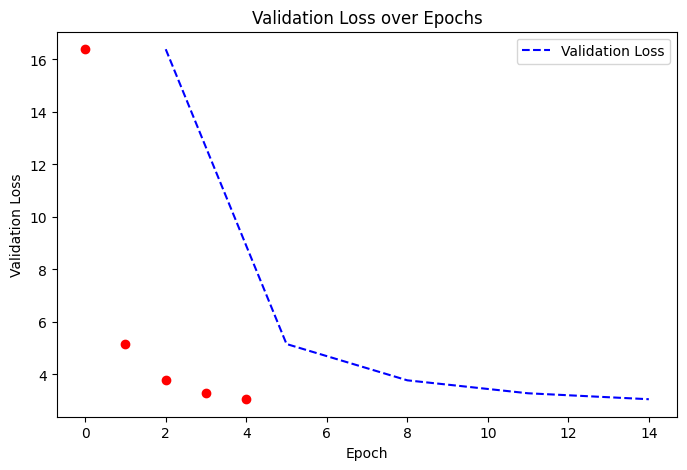

Training completed successfully!


In [ ]:
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

model_name = "google/gemma-3-270m"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last transformer block 
num_layers = len(model.model.layers)
print(f"Total number of layers: {num_layers}")

# Unfreeze only the last layer
last_n_layers = 4
for i in range(num_layers - last_n_layers, num_layers):
    for param in model.model.layers[i].parameters():
        param.requires_grad = True
    print(f"Unfroze layer {i}")


if hasattr(model.model, 'norm'):
    for param in model.model.norm.parameters():
        param.requires_grad = True
    print("Unfroze final layer norm")

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

# Add padding token 
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Prepare dataset
df = train.copy()
df1 = val.copy()

# Map labels 
label2id = {"e": "e", "c": "c", "n": "n"}
df["label"] = df["label"].map(label2id)
df1["label"] = df1["label"].map(label2id)

# Fill missing reason 
df["reasoning"] = df["reasoning"].fillna("")
df1["reasoning"] = df1["reasoning"].fillna("")

# Build input and target
def make_input(row):
    return f"جمله اول: {row['premise']}\nجمله دوم: {row['hypothesis']}\nنتیجه:"

def make_target(row):
    return f"{row['reasoning']} [LABEL] {row['label']}"

df["input_text"] = df.apply(make_input, axis=1)
df["target_text"] = df.apply(make_target, axis=1)
df1["input_text"] = df1.apply(make_input, axis=1)
df1["target_text"] = df1.apply(make_target, axis=1)

train_ds = Dataset.from_pandas(df)
val_ds = Dataset.from_pandas(df1)

# Tokenization  
max_input_len = 256
max_target_len = 128

def tokenize_fn(examples):
    # Tokenize inputs
    model_inputs = tokenizer(
        examples["input_text"],
        max_length=max_input_len,
        truncation=True,
        padding=False
    )

    # Tokenize targets
    labels = tokenizer(
        examples["target_text"],
        max_length=max_target_len,
        truncation=True,
        padding=False
    )


    input_ids = []
    attention_mask = []
    labels_list = []

    for i in range(len(examples["input_text"])):
        # Tokenize input and target separately
        input_tokens = model_inputs["input_ids"][i]
        target_tokens = labels["input_ids"][i]

        # Combine input and target
        combined_input_ids = input_tokens + target_tokens + [tokenizer.eos_token_id]
        combined_attention_mask = [1] * len(combined_input_ids)

        # Create labels (we want to predict only the target part)
        # Use -100 for input part (to ignore in loss calculation)
        combined_labels = [-100] * len(input_tokens) + target_tokens + [tokenizer.eos_token_id]

        # Pad sequences to max length
        max_length = max_input_len + max_target_len + 1  # +1 for EOS

        if len(combined_input_ids) > max_length:
            combined_input_ids = combined_input_ids[:max_length]
            combined_attention_mask = combined_attention_mask[:max_length]
            combined_labels = combined_labels[:max_length]
        else:
            padding_length = max_length - len(combined_input_ids)
            combined_input_ids = combined_input_ids + [tokenizer.pad_token_id] * padding_length
            combined_attention_mask = combined_attention_mask + [0] * padding_length
            combined_labels = combined_labels + [-100] * padding_length

        input_ids.append(combined_input_ids)
        attention_mask.append(combined_attention_mask)
        labels_list.append(combined_labels)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels_list
    }

# Apply tokenization
train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(tokenize_fn, batched=True, remove_columns=val_ds.column_names)

# TrainingArguments & Trainer
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # causal LM, not masked LM
    pad_to_multiple_of=8
)

training_args = TrainingArguments(
    output_dir="./gemma3_finetuned_reason_label",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",  
    save_strategy="epoch",
    logging_steps=50,
    bf16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to='none',
    save_total_limit=2,
    prediction_loss_only=True  
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train
trainer.train()

# Save final model
model.save_pretrained("./gemma3_textual_entailment_fa")
tokenizer.save_pretrained("./gemma3_textual_entailment_fa")

# Evaluation & plots
def extract_label_from_generation(text):
    """Extract label from generated text"""
    if "[LABEL]" in text:
        return text.split("[LABEL]")[-1].strip().split()[0]  # Get first word after [LABEL]
    return ""

# Manual evaluation function
def evaluate_model(trainer, dataset, tokenizer, num_samples=100):
    model.eval()
    predictions = []
    true_labels = []

    # Sample some examples for evaluation
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    for idx in indices:
        example = dataset[idx]

        input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)

        # Generate text
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred_label = extract_label_from_generation(generated_text)

        # Get true label (from the original target)
        # This is a bit tricky since we modified the dataset
        # You might need to store original labels separately

        predictions.append(pred_label)

    return predictions

# Plot training loss
logs = pd.DataFrame(trainer.state.log_history)
if 'loss' in logs.columns and len(logs) > 0:
    train_logs = logs[logs['loss'].notnull()]
    if not train_logs.empty:
        plt.figure(figsize=(8,5))
        plt.plot(train_logs['loss'], label="Train Loss")
        plt.title("Training Loss over Steps")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Plot eval loss
eval_logs = logs[logs['eval_loss'].notnull()]
if not eval_logs.empty:
    plt.figure(figsize=(8,5))
    plt.plot(eval_logs['eval_loss'], color='blue', linestyle='--', label="Validation Loss")
    plt.scatter(range(len(eval_logs)), eval_logs['eval_loss'], color='red')
    plt.title("Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.show()

print("Training completed successfully!")

In [ ]:
# COMPREHENSIVE EVALUATION ON VALIDATION SET
def extract_label_from_generation(text):
    """Extract label from generated text - robust version"""
    # Look for [LABEL] pattern first
    if "[LABEL]" in text:
        parts = text.split("[LABEL]")
        if len(parts) > 1:
            label_part = parts[-1].strip()
            # Extract first single character (e, c, n)
            match = re.search(r'\b([ecn])\b', label_part)
            if match:
                return match.group(1)

    # look for single character labels in the text
    matches = re.findall(r'\b([ecn])\b', text)
    if matches:
        return matches[-1]  # Return the last found label

    return ""

def evaluate_model_comprehensive(model, tokenizer, val_dataset, original_labels, max_samples=None):
    """Comprehensive evaluation on validation set"""
    model.eval()
    predictions = []

    if max_samples is None:
        max_samples = len(val_dataset)

    print(f"Evaluating on {max_samples} samples...")

    for i in range(max_samples):
        if i % 50 == 0:
            print(f"Processing sample {i}/{max_samples}")

        example = val_dataset[i]

        # Extract input part 
        input_ids = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)

        # Find where target starts (where labels become != -100)
        labels = example["labels"]
        target_start_idx = None
        for idx, label_val in enumerate(labels):
            if label_val != -100:
                target_start_idx = idx
                break

        if target_start_idx is None:
            # If no target found, use the whole sequence
            input_ids_for_generation = input_ids
            attention_mask_for_generation = attention_mask
        else:
            # Use only the input part for generation
            input_ids_for_generation = input_ids[:, :target_start_idx]
            attention_mask_for_generation = attention_mask[:, :target_start_idx]

        # Generate text
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids_for_generation,
                attention_mask=attention_mask_for_generation,
                max_new_tokens=50,
                num_return_sequences=1,
                temperature=0.1,  # Lower temperature for more deterministic results
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                early_stopping=True
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        pred_label = extract_label_from_generation(generated_text)
        predictions.append(pred_label)

    # Calculate metrics
    true_labels = original_labels[:max_samples]

    # Filter out samples where prediction failed
    valid_indices = [i for i, pred in enumerate(predictions) if pred in ["e", "c", "n"]]
    valid_predictions = [predictions[i] for i in valid_indices]
    valid_true_labels = [true_labels[i] for i in valid_indices]

    if len(valid_predictions) == 0:
        print("No valid predictions found!")
        return

    # Calculate metrics
    accuracy = accuracy_score(valid_true_labels, valid_predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        valid_true_labels, valid_predictions, labels=["e", "c", "n"], average='weighted'
    )

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        valid_true_labels, valid_predictions, labels=["e", "c", "n"]
    )

    # Print results
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Total samples evaluated: {max_samples}")
    print(f"Valid predictions: {len(valid_predictions)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("\nPer-class metrics:")
    for i, label in enumerate(["e", "c", "n"]):
        print(f"  Label '{label}': Precision={precision_per_class[i]:.4f}, "
              f"Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}, "
              f"Support={support_per_class[i]}")

    print("\nDetailed Classification Report:")
    print(classification_report(valid_true_labels, valid_predictions,
                               labels=["e", "c", "n"], target_names=["Entailment", "Contradiction", "Neutral"]))

    # Confusion Matrix 
    from collections import Counter
    print("\nConfusion Matrix (predictions × true):")
    label_order = ["e", "c", "n"]
    confusion = {}
    for true, pred in zip(valid_true_labels, valid_predictions):
        key = (true, pred)
        confusion[key] = confusion.get(key, 0) + 1

    print("     e    c    n")
    for true_label in label_order:
        row = f"{true_label}: "
        for pred_label in label_order:
            count = confusion.get((true_label, pred_label), 0)
            row += f"{count:4d} "
        print(row)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# Run comprehensive evaluation
print("Starting comprehensive evaluation...")
eval_results = evaluate_model_comprehensive(
    model=model,
    tokenizer=tokenizer,
    val_dataset=val_ds,
    original_labels=original_val_labels,
    max_samples=len(val_ds)  # Evaluate on entire validation set
)

# Plot training metrics
logs = pd.DataFrame(trainer.state.log_history)

# Plot training loss
if 'loss' in logs.columns and len(logs) > 0:
    train_logs = logs[logs['loss'].notnull()]
    if not train_logs.empty:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_logs['loss'], label="Train Loss")
        plt.title("Training Loss over Steps")
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.legend()

# Plot eval loss
eval_logs = logs[logs['eval_loss'].notnull()]
if not eval_logs.empty:
    plt.subplot(1, 2, 2)
    plt.plot(eval_logs['eval_loss'], color='blue', linestyle='--', label="Validation Loss")
    plt.scatter(range(len(eval_logs)), eval_logs['eval_loss'], color='red')
    plt.title("Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Training and evaluation completed successfully!")

Starting comprehensive evaluation...


NameError: name 'model' is not defined